<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Advanced Algorithm 2: Stacked Ensemble Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#data-setup) 

[Civis Analytics Stacked Classifier](#civis-analytics-stackedclassifier)

&nbsp;&nbsp;&nbsp;[Choose Component Models](#choose-component-models)  
&nbsp;&nbsp;&nbsp;[Set Grid Search Parameters and Train](#set-grid-search-parameters-and-train)  

[Compare to Simple Ensemble](#compare-to-simple-ensemble)  
[Summary](#summary)

# Stacked Ensemble Classifier Introduction <a class="anchor" id="introduction"></a>

In the last notebook, we looked at creating a simple ensemble by averaging the predictions of a set of models. One of the drawbacks of this approach is that it treats every model the same. However, not all models are equally accurate, and not all models perform well for every household. Stacking addresses these limitations of model averaging.

Model stacking, or meta-estimation, is a popular technique used to win machine learning competitions. In model stacking, the predictions of each model in the ensemble are used as features, often referred to as _meta features_, to train a new classifier (or, meta classifier). In this way, the "stack" is composed of two _levels_: level 1, which is composed of independent estimators, and level 2, which treats the predictions of the level 1 models as features and is trained to predict the same ouput variable using these features as input.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

In order to avoid overfitting the training set, it is important to use a proper validation technique when training a stacked model. This is a crucial point. In order to train a stacked model using $l$ base estimators to generate features for meta estimator $M$. A very common approach consists of,


1. **Preprocess** Split training data $X$ into $k$ folds $(X_1, ..., X_k)$.
2. **Train Level 1** For each model $L_i$ where ${i: 1, ..., l}$, fit $L_i$ using $k-1$ folds, predict on the remaining fold. Repeat this cycle $k$ times, until $L_i$ has predicted on _every_ fold. The result will be a matrix of "out-of-sample" (out of the particular fold) predictions for every row in the training set.
3. **Train Level 2** Train the meta estimator $M$ using the $l$-dimensional features generated in step 2. If $X$ has $1000$ samples then the meta estimator training data has shape $1000 \times l$.
4. **Optional** After meta features are generated, refit level 1 models using full training set. Do not do anything to level 2 models!

The key point is that level 2 features need to be generated using out-of-fold predictions from level 1. Otherwise the level 2 meta estimator will overfit the training data severely, and the stacked model may perform worse than any of its components. In fact, if executed appropriately, it can be shown that stacked modeling will, with probability approaching 1, never perform worse than its best base estimator.

# Data setup <a class="anchor" id="data-setup"></a>

First we load the standard libraries and data.

In [1]:
%matplotlib inline

import os
import sys
import json

from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display

import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from models.evaluation import evaluate_model
from visualization import visualize
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

import warnings
warnings.filterwarnings('ignore')

ALGORITHM_NAME = 'ensemble'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_test, y_test, w_test = load_data(TEST_PATH)

# Stacked Classifier Implementation <a class="anchor" id="civis-analytics-stackedclassifier"></a>

The Scikit Learn library does not include any built-in stacking estimators. Given the subtle aspects of training, described in the introduction above, it is worth looking for a well-tested implmentation of the technique. An implementation of a stacking estimator is provided in the "Civis Machine Learning Extensions" package, `civismlext`, on [github](https://github.com/civisanalytics/civisml-extensions).

This implementation uses the same application programming interface (api) as the [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object from Scikit Learn, in which component objects are given string identifiers and passed as a list into the classifier.

First, let's import the component models.

## Choose Component Models <a class="anchor" id="choose-component-models"></a>

As with the simple ensemble model, we choose from the top performing models as components for the ensemble. This means we'll be using logistic regression, linear discriminant analysis, multi-layer perception, and XGBoost as the components:

**Level 1**
* `LogisticRegression`
* `LinearDiscriminantAnalysis`
* `MLPClassifier`

**Level 2**
* `XGBClassifier`

It is common for participants in machine learning competitions to use XGBoost as the meta-estimator, so we will do that here.

In [3]:
from numpy.random import RandomState

# base estimators
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# meta estimator
from xgboost import XGBClassifier

# stacking pipeline
from civismlext.stacking import StackedClassifier

# class balancing
from sklearn.base import BaseEstimator
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


# training pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer

SEED = 2018

In [4]:
base_estimator_list = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('lda', LinearDiscriminantAnalysis()),
    ('mlp', MLPClassifier(random_state=SEED)),

    # the last estimator is always the meta estimator
    ('metaxgb', XGBClassifier(random_state=SEED)),
]

stack = StackedClassifier(base_estimator_list)

## Set Grid Search Parameters And Train <a class="anchor" id="set-grid-search-parameters-and-train"></a>

As opposed to using many versions of the same model, as we did in the simple ensemble, here we will grid search over all of the parameters used in each model type. This includes pre-processing choices such as class-balancing techniques, as well as model-specific parameters like number of hidden layers in the multi-layer perception.

The module `civismlext.stacking` works seamlessly with the scikit-learn gridsearch object we've used throughout these notebooks. However, in order to simplify the computational complexity of the training pipeline, we will restrict our search over class-weighting techniqes to include only under-sampling and over-sampling, plus we will only search with respect to _all_ of the level one models. In other words, the final model will use one of the class-weighting techniques for the level one models, but only one (not a different one for each component model). Although it is theoretically possible to train such a model (using different class-weighting techniques for each component model), this process would substantially complicate the algorithm as described in the introduction. The reason is that the number of samples used in training would then be a function of the model, leading to some samples with predictions from _every_ model and some samples with predictions from only _some_ models.

To construct an object that the scikit learn gridsearch object can use to test different sampling techniques, we must first create a simple class that contains the required methods needed in training. The easiest way to do this is to first inherit from the scikit learn `BaseEstimator` class, and then [override](http://blog.thedigitalcatonline.com/blog/2014/05/19/method-overriding-in-python/) the inherited `fit` methods with the ones we want. This way we ensure that the class also has any other methods and properties it may be expected to have by the gridsearch training object.

In [5]:
class Sampler(BaseEstimator):
    def __init__(self, technique=None):        
        self.technique = technique

    def fit(self, X, y):
        self.technique.fit(X, y)
        return self
        
    def sample(self, X, y):
        return self.technique.sample(X, y)
    
    def fit_sample(self, X, y):
        return self.technique.fit(X, y).sample(X, y)

Our full pipeline is now:

1. Apply sampling technique to preprocess data
2. Train stacked classifier using preprocessed data

To implement both of these steps we use the scikit learn pipeline object described above, which allows us to define a list representing ordered operations, and pass strings to refer to those operations. This allows us to specify grid search parameters as we have done throuhgout this project, using the scikit-learn `__` syntax, described in full in the [Pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [6]:
pipe = Pipeline([('sampler', Sampler()), ('stack', stack)])

### Now specify components of the gridsearch

For fast training, we provide a sparse set of gridsearch parameters. Otherwise, the complete set of model parameters considered in the earlier Indonesia notebooks will be used (this could take days to train).

The seed of training is controlled by the `SEARCH_FULL_GRID` parameter below. If `True`, the slower training route is taken. IF `False`, the faster training route is taken.

In [7]:
# false by default for faster training
SEARCH_FULL_GRID = False

In [8]:
if SEARCH_FULL_GRID:
    # this grid searches all parameters from the previous notebooks
    param_grid = {
                    # Logistic Regression
                    'stack__lr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],

                    # MLP
                    'stack__mlp__hidden_layer_sizes': [(512,), (1024,)],
                    'stack__mlp__alpha': [1.0],

                    # LDA
                    'stack__lda__solver': ['svd'],

                    # Meta-Classifier: XGB
                    'stack__metaxgb__max_depth': np.arange(3,6,2),
                    'stack__metaxgb__objective':['binary:logistic'],
                    'stack__metaxgb__learning_rate': [0.05],
                    'stack__metaxgb__min_child_weight': [11],
                    'stack__metaxgb__silent': [0],
                    'stack__metaxgb__subsample': [0.8],
                    'stack__metaxgb__colsample_bytree': [0.7],
                    'stack__metaxgb__n_estimators': [1000],
                    'stack__metaxgb__seed': [1430],

                    # Class Balancing
                    'sampler__technique': [RandomUnderSampler(random_state=SEED), SMOTE(random_state=SEED)],

                    # Cross-Validation
                    'stack__cv': [3, 5],
    }

else:
    # this faster grid only corresponds to one pipeline
    param_grid = {
                    # Logistic Regression
                    'stack__lr__C': [0.001],

                    # MLP
                    'stack__mlp__hidden_layer_sizes': [(512,)],
                    'stack__mlp__alpha': [1.0],

                    # LDA
                    'stack__lda__solver': ['svd'],

                    # Meta-Classifier: XGB
                    'stack__metaxgb__max_depth': np.arange(3),
                    'stack__metaxgb__objective':['binary:logistic'],
                    'stack__metaxgb__learning_rate': [0.05],
                    'stack__metaxgb__min_child_weight': [11],
                    'stack__metaxgb__silent': [0],
                    'stack__metaxgb__subsample': [0.8],
                    'stack__metaxgb__colsample_bytree': [0.7],
                    'stack__metaxgb__n_estimators': [1000],
                    'stack__metaxgb__seed': [1430],

                    # Class Balancing
                    'sampler__technique': [RandomUnderSampler(random_state=SEED)],

                    # Cross-Validation
                    'stack__cv': [3],
    }

Scoring functions used to evaluate the out of fold predictions in the grid search.

In [9]:
scoring = {
    'precision': make_scorer(precision_score), 
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

Finally, we instantiate the grid search object. It is this object that we'll `fit()`!

In [10]:
grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    scoring=scoring, 
                    refit='f1')

In [11]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sampler', Sampler(technique=None)), ('stack', StackedClassifier(cv=3,
         estimator_list=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2...    seed=None, silent=True, subsample=1))],
         n_jobs=1, pre_dispatch='2*n_jobs', verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'stack__lr__C': [0.001], 'stack__mlp__hidden_layer_sizes': [(512,)], 'stack__mlp__alpha': [1.0], 'stack__lda__solver': ['svd'], 'stack__metaxgb__max_depth': array([0, 1, 2]), 'stack__metaxgb__objective': ['binary:logistic'], 'stack__metaxgb__learning_rate': [0.05], 'stack__metaxgb__min_c...dom_state=2018, ratio='auto', replacement=False,
          return_indices=False)], 'stack__cv': [3]},
       pre_dispatch='2*n_jobs', refit='f1', return_

# Compare To Simple Ensemble <a class="anchor" id="compare-to-simple-ensemble"></a>

Look at the parameters chosen by the grid search.

In [12]:
grid.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator__memory': None,
 'estimator__steps': [('sampler', Sampler(technique=None)),
  ('stack', StackedClassifier(cv=3,
            estimator_list=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=2018, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False)), ('lda', Li...e=2018, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=True, subsample=1))],
            n_jobs=1, pre_dispatch='2*n_jobs', verbose=0))],
 'estimator__sampler': Sampler(technique=None),
 'estimator__stack': StackedClassifier(cv=3,
          estimator_list=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=2018, solver='liblinear', tol=0.

In [13]:
y_test = y_test.astype(int)
y_prob = grid.predict_proba(X_test)[:, 1]
y_pred = grid.predict(X_test)

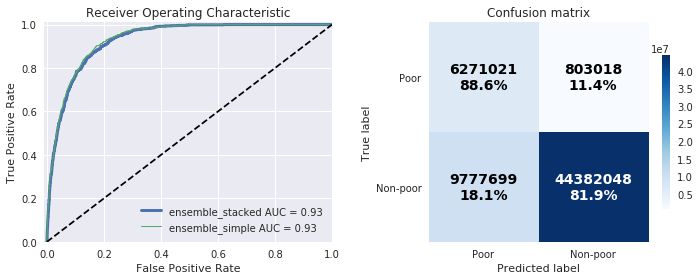

,ensemble_stacked,ensemble_simple
accuracy,0.827208,0.845008
recall,0.886484,0.873189
precision,0.390749,0.418192
f1,0.542411,0.565535
cross_entropy,0.352263,0.34436
roc_auc,0.929823,0.93394
cohen_kappa,0.44074,0.464792


In [14]:
metrics = evaluate_model(y_test, 
                         y_pred, 
                         y_prob,
                         w_test,
                         compare_models=['ensemble_simple'],
                         model_name='stacked',
                         prefix=ALGORITHM_NAME,
                         country=COUNTRY,
                         predict_pov_rate=False,
                         store_model=True,
                         model=grid)

The simple ensemble performs better on many metrics, which may seem surprising since this is a more complicated model. However, the result is not so surprising if we keep in mind a couple of crucial points. First, the simple ensemble had many more component models (10 compared to 4). Second, and probably more importantly, the simple ensemble consisted of many different class balancing techniques, whereas the stacked model had to choose one to use for all models. While it seems like a small difference, the heterogeneity in model prediction introduced by the simple ensemble is likely much more than that of the stacked model.

# Summary <a class="anchor" id="summary"></a>

The stacked model, while complicated to implement and train, seems to have been outperformed by its simpler counterpart. However, as mentioned in the previous section, this is likely due to the relative size of the stacked model compared to the simple ensemble. Even this simpler stacked model takes more than 24 hours to train on a 32 core machine, so making a more complex grid search, while likely to improve performance, would be a serious computational undertaking. This is why it is often the case that algorithms that win many machine learning competitions take days to train.